In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import b3d
import sys

sys.path.append(str(b3d.get_root_path()))

In [135]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [298]:
path = b3d.get_assets_path() / 'mydata/pan_through_plantroom.npz'
ftd_og = b3d.io.FeatureTrackData.load(str(path))

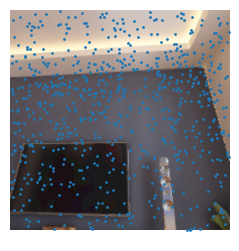

In [299]:
ftd_og.slice_time(0, 10).quick_plot(t=20, downsize=1)

In [300]:
ftd = ftd_og.strip_depth_channel()
ftd


FeatureTrackData:
    Timesteps: 76
    Num Keypoints: 1195
    Sensor shape (width x height): 200 x 200

In [301]:
def get_patch_around_region(rgb, center, size=11):
    y, x = center
    half_size = size // 2
    return rgb[y-half_size:y+half_size, x-half_size:x+half_size]

def get_patch_around_region_with_padding(rgb, center, size=11, pad_value=-1):
    center = jnp.array(center, dtype=jnp.int32)
    y, x = center
    half_size = size // 2
    padded_rgb = jnp.pad(rgb, ((half_size, half_size), (half_size, half_size), (0, 0)), mode='constant', constant_values=-1)
    return jax.lax.dynamic_slice(padded_rgb, (y, x, 0), (size, size, 3))

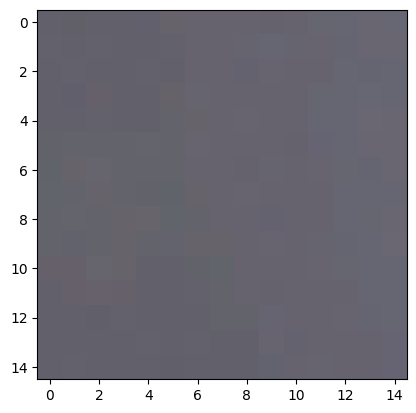

In [302]:
patch = get_patch_around_region_with_padding(
    ftd.rgb[0],
    # [int(x) for x in ftd.observed_keypoints_positions[0, 8]],
    jnp.array(ftd.observed_keypoints_positions[0, 8], dtype=jnp.int32),
    size=15
)
plt.imshow(patch)

In [303]:
def get_measure_of_spread(patch):
    """Quick measure of spread of a patch of pixels.  Patches with values below 0.2 are close to uniform."""
    patch = patch.reshape(-1, 3)
    
    # ignore positions where the rgb is -1
    num_valid = jnp.sum(patch[..., 0] != -1)
    zeroed_in_ignored = jnp.where(patch == -1, 0, patch)
    
    mean = jnp.sum(zeroed_in_ignored, axis=1) / num_valid
    diff_norms = jnp.linalg.norm(patch - mean[:, None], axis=1)
    max_norm = jnp.max(diff_norms)
    return max_norm

get_measure_of_spread(patch)

Array(0.7246216, dtype=float32)

In [305]:
def get_indices_with_large_spreads(ftd, threshold=1.0):
    spreads = jax.vmap(lambda i: get_measure_of_spread(
        get_patch_around_region_with_padding(
            ftd.rgb[0],
            jnp.array(ftd.observed_keypoints_positions[0, i], dtype=jnp.int32),
            size=11
        )
    ))(jnp.arange(0, ftd.observed_keypoints_positions.shape[1]))
    return jnp.where(spreads > threshold)[0]

ftd.slice_keypoints(get_indices_with_large_spreads(ftd))


FeatureTrackData:
    Timesteps: 76
    Num Keypoints: 786
    Sensor shape (width x height): 200 x 200

In [306]:
(
    ftd
    .slice_time(10)
    .remove_points_invisible_at_frame0()
)


FeatureTrackData:
    Timesteps: 66
    Num Keypoints: 686
    Sensor shape (width x height): 200 x 200

In [173]:
(
    ftd
    .slice_time(10)
    .remove_points_invisible_at_frame0()
    .slice_keypoints(get_indices_with_large_spreads(ftd, threshold=1.0))
)


FeatureTrackData:
    Timesteps: 66
    Num Keypoints: 631
    Sensor shape (width x height): 200 x 200

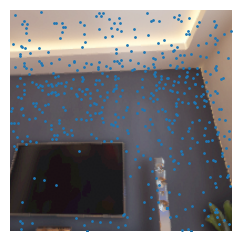

In [307]:
(
    ftd
    .slice_time(10)
    .remove_points_invisible_at_frame0()
    .slice_keypoints(get_indices_with_large_spreads(ftd, threshold=1.0))
).quick_plot(t=0, downsize=1)

In [308]:
def get_plot(t):
    return (
        ftd
        .slice_time(10)
        .remove_points_invisible_at_frame0()
        .slice_keypoints(jnp.array([t]))
    ).quick_plot(t=0, downsize=1)

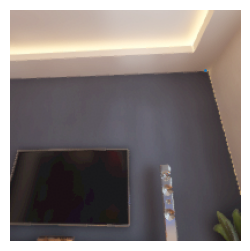

In [309]:
get_plot(213)

In [216]:
jnp.argmin(jnp.linalg.norm((
    ftd
    .slice_time(10)
    .remove_points_invisible_at_frame0()
).observed_keypoints_positions[0, :] - jnp.array([170., 50.]), axis=1))

Array(213, dtype=int32)

In [219]:
## OK, let's use this patch.

In [234]:
IDX = 213
onekeypoint_ftd = (
    ftd_og
    .slice_time(10)
    .remove_points_invisible_at_frame0()
    .slice_keypoints(jnp.array([IDX]))
)

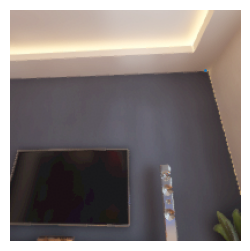

In [251]:
onekeypoint_ftd.slice_time(0, 10).quick_plot(t=0, downsize=1)

In [323]:
onekeypoint_ftd.uv[0, 0]

Array([168.50208,  51.74899], dtype=float32)

In [321]:
onekeypoint_ftd.rgb[0, 195, 5]

Array([0.24705882, 0.2509804 , 0.2784314 ], dtype=float32)

In [320]:
onekeypoint_ftd.rgb[0, 195, 195]

Array([0.30980393, 0.32156864, 0.27450982], dtype=float32)

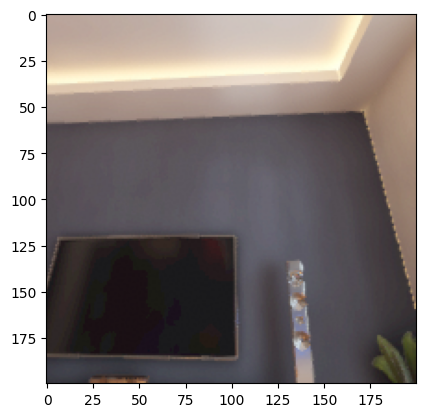

In [313]:
plt.imshow(onekeypoint_ftd.slice_time(0, 10).rgb[0])

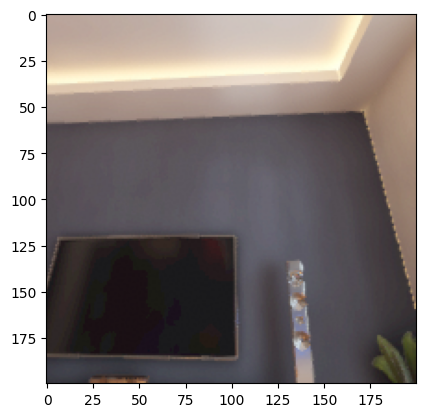

In [253]:
plt.imshow(onekeypoint_ftd.rgb[0])

In [270]:
def add_border_to_image(rgb, center, size):
    """Returns a version of `rgb` with a black square border around the center."""
    x, y = jnp.array(center, dtype=jnp.int32)
    half_size = size // 2
    # return rgb.at[y-half_size:y+half_size, x-half_size:x+half_size].set(0.)
    
    rgb = rgb.at[y-half_size:y+half_size, x-half_size].set(0.)
    rgb = rgb.at[y-half_size:y+half_size, x+half_size].set(0.)
    rgb = rgb.at[y-half_size, x-half_size:x+half_size].set(0.)
    rgb = rgb.at[y+half_size, x-half_size:x+half_size+1].set(0.)
    return rgb

In [271]:
onekeypoint_ftd.observed_keypoints_positions[0, 0]

Array([168.50208,  51.74899], dtype=float32)

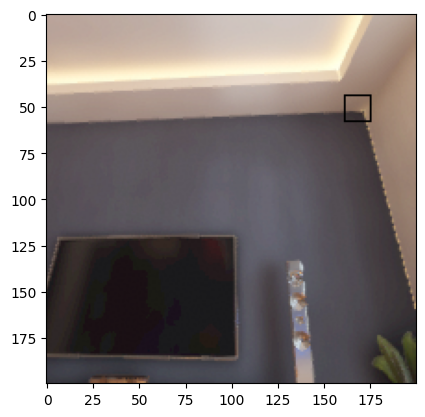

In [272]:
plt.imshow(add_border_to_image(onekeypoint_ftd.rgb[0], onekeypoint_ftd.observed_keypoints_positions[0, 0], 15))

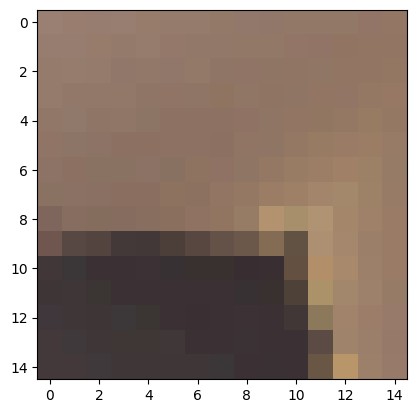

In [266]:
patch = get_patch_around_region_with_padding(
    onekeypoint_ftd.rgb[0],
    onekeypoint_ftd.observed_keypoints_positions[0, 0],
    size=15
)
plt.imshow(patch)

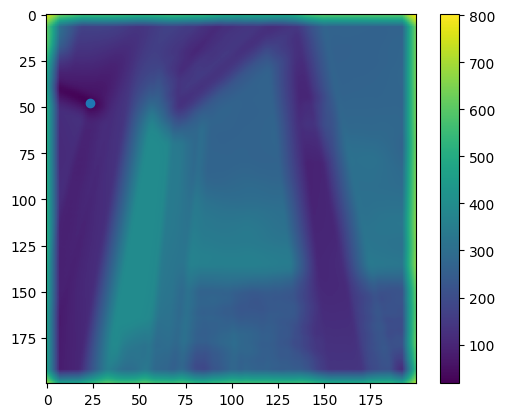

In [297]:
def patch_l1_error_at_position(rgb, center, patch):
    """Returns the L1 error between the patch and the patch centered at the given position."""
    return jnp.sum(jnp.abs(patch - get_patch_around_region_with_padding(rgb, center, size=15)))

def get_errors_across_image(rgb, patch):
    height, width, _ = rgb.shape
    return jax.vmap(jax.vmap(
        lambda x, y: patch_l1_error_at_position(rgb, (x, y), patch),
        in_axes=(0, None)
    ), in_axes=(None, 0))(
        jnp.arange(0, height), jnp.arange(0, width)
    )

def get_best_fit_pos(rgb, patch):
    errors = get_errors_across_image(rgb, patch)
    min_error = jnp.min(errors)
    y, x = jnp.where(errors == min_error)
    return y[0], x[0]

t = 40
errors_at_each_position = get_errors_across_image(onekeypoint_ftd.rgb[t], patch)
plt.imshow(errors_at_each_position)
plt.colorbar()
y, x = get_best_fit_pos(onekeypoint_ftd.rgb[t], patch)
plt.scatter([x], [y])

In [ ]:
from tests.sama4d.video_to_tracks.task import KeypointTrackingTask

task = KeypointTrackingTask()